In [73]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pickle
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

import os
import glob

# 코드 셀 실행 후 경고를 무시
# import warnings
# warnings.filterwarnings(action='ignore')

In [74]:
base_path = "/root/"

dt = pd.read_csv(base_path + "train.csv")
dt_test = pd.read_csv(base_path + "test.csv")

df_bus = pd.read_csv(base_path + "bus_feature.csv")
df_metro = pd.read_csv(base_path + "subway_feature.csv")

extra_data_path = '/root/extra_data/'


### Load Table

In [75]:
# pickle에서 데이터프레임 다시 불러오기
with open('/root/data.pickle', 'rb') as f:
    df = pickle.load(f)

### Feature Engineering

In [76]:
# df['공시가격리스트']= df['공시가격리스트'].astype(str)
df['평균공시가격']=df['평균공시가격'].interpolate(method='linear', axis=0)

In [77]:
df.columns

Index(['번지', '본번', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '구', '동', '계약년', '계약월', '평균공시가격', '계약일', 'date'],
      dtype='object')

In [78]:
df["date"]

0         2017-12-08
1         2017-12-22
2         2017-12-28
3         2018-01-03
4         2018-01-08
             ...    
1128089   2023-07-19
1128090   2023-07-25
1128091   2023-08-27
1128092   2023-09-02
1128093   2023-09-04
Name: date, Length: 1128094, dtype: datetime64[ns]

In [79]:
df["계약년"] = df["계약년"].astype(int)

In [80]:
df["계약월"].dtype

dtype('O')

In [81]:
df["건축년도"] = df["건축년도"].astype(int)

In [82]:
df['yrs_diff'] = df["계약년"] - df["건축년도"]

In [83]:
# Use glob to find all files that match the pattern
file_paths = glob.glob(extra_data_path + "/KOSPI_*.csv")

# Initialize an empty list to store the dataframes
dfs = []

# Iterate over the file paths and read each CSV file into a dataframe
for file_path in file_paths:
    kospi_df_yr = pd.read_csv(file_path, encoding="euc-kr")
    dfs.append(kospi_df_yr)

kospi_df = pd.concat(dfs, ignore_index=True)
kospi_df = kospi_df.drop(columns=['시가', '고가', '저가'])

In [84]:
kospi_df.rename(columns={"일자":"date", "종가":"Close"}, inplace=True)
kospi_df["date"] = kospi_df['date'].str.replace('/', '-')
kospi_df["date"] = pd.to_datetime(kospi_df["date"])
kospi_df.sort_values(by='date', ascending=True, inplace=True)

In [85]:
kospi_df["Close_delay120d"] = kospi_df["Close"].shift(120)

In [86]:
df = pd.merge(left=df, right=kospi_df, on='date', how='left')

In [87]:
df.drop(columns=['date', 'Close', '대비', '등락률', '거래량', '거래대금', '상장시가총액'], inplace=True)

In [88]:
df["Close_delay120d"] = df["Close_delay120d"].interpolate(method='linear', axis=0)

In [89]:
df.columns

Index(['번지', '본번', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '구', '동', '계약년', '계약월', '평균공시가격', '계약일', 'yrs_diff',
       'Close_delay120d'],
      dtype='object')

### Train

In [90]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(1118822, 17) (9272, 17)


In [91]:
# 변수 삭제 및 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '계약년월', '층', '건축년도', 'target', '계약년', '평균공시가격', '계약일', 'yrs_diff', 'Close_delay120d']
범주형 변수: ['번지', '본번', '아파트명', '도로명', '구', '동', '계약월']


In [92]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


In [93]:
y_train = df_train['target']
X_train = df_train.drop(['target'], axis=1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [94]:
import optuna

def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 1000, 5000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    num_leaves = trial.suggest_int('num_leaves', 100, 1000)
    min_child_samples = trial.suggest_int('min_child_samples', 50, 500)
    feature_fraction = trial.suggest_float('feature_fraction', 0.5, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.5, 1.0)
    lambda_l1 = trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True)  # Increase L1 regularization
    lambda_l2 = trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True)  # Increase L2 regularization

    # Create the LGBMRegressor model with the suggested hyperparameters
    gbm = lgb.LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, num_leaves=num_leaves,
                            min_child_samples=min_child_samples, feature_fraction=feature_fraction,
                            bagging_fraction=bagging_fraction, lambda_l1=lambda_l1, lambda_l2=lambda_l2, verbosity=-1)

    # Train the model
    gbm.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )
    
    # Compute the validation RMSE
    val_rmse = gbm.best_score_['valid_1']['rmse']
    return val_rmse

def optimize_hyperparameters(n_trials=100, early_stopping=50, log_evaluation=100):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Create the final model with the best hyperparameters
    best_model = lgb.LGBMRegressor(**best_params)

    # Train the final model with early stopping and evaluation logging
    best_model.fit(X_train, y_train,
                   eval_set=[(X_train, y_train), (X_val, y_val)],
                   eval_metric='rmse',
                   callbacks=[lgb.early_stopping(stopping_rounds=early_stopping),
                              lgb.log_evaluation(period=log_evaluation, show_stdv=True)])

    return best_model

In [95]:
best_model = optimize_hyperparameters(n_trials=5)

[I 2024-03-29 05:08:58,338] A new study created in memory with name: no-name-d2a9f2b1-de4d-45c8-9910-3daa56febac3


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 8070.14	training's l2: 6.51272e+07	valid_1's rmse: 8346.18	valid_1's l2: 6.96587e+07
[200]	training's rmse: 7243.28	training's l2: 5.24651e+07	valid_1's rmse: 7587.98	valid_1's l2: 5.75774e+07
[300]	training's rmse: 6802.22	training's l2: 4.62702e+07	valid_1's rmse: 7193.21	valid_1's l2: 5.17423e+07
[400]	training's rmse: 6505.08	training's l2: 4.23161e+07	valid_1's rmse: 6929.4	valid_1's l2: 4.80165e+07
[500]	training's rmse: 6277.37	training's l2: 3.94054e+07	valid_1's rmse: 6737.57	valid_1's l2: 4.53948e+07
[600]	training's rmse: 6100.96	training's l2: 3.72217e+07	valid_1's rmse: 6596.13	valid_1's l2: 4.35089e+07
[700]	training's rmse: 5945.56	training's l2: 3.53496e+07	valid_1's rmse: 6475.08	valid_1's l2: 4.19267e+07
[800]	training's rmse: 5818.55	training's l2: 3.38556e+07	valid_1's rmse: 6378.57	valid_1's l2: 4.06861e+07
[900]	training's rmse: 5714.25	training's l2: 3.26527e+07	valid_1's rmse: 63

[I 2024-03-29 05:09:20,673] Trial 0 finished with value: 5982.607962054058 and parameters: {'n_estimators': 1662, 'max_depth': 10, 'num_leaves': 207, 'min_child_samples': 339, 'feature_fraction': 0.9461212325526605, 'bagging_fraction': 0.8729579689706426, 'lambda_l1': 0.36146977400729585, 'lambda_l2': 4.541580566255599e-06}. Best is trial 0 with value: 5982.607962054058.


Did not meet early stopping. Best iteration is:
[1662]	training's rmse: 5173.92	training's l2: 2.67695e+07	valid_1's rmse: 5982.61	valid_1's l2: 3.57916e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7436.49	training's l2: 5.53014e+07	valid_1's rmse: 7814.31	valid_1's l2: 6.10634e+07
[200]	training's rmse: 6544.7	training's l2: 4.2833e+07	valid_1's rmse: 7026.72	valid_1's l2: 4.93749e+07
[300]	training's rmse: 6113.02	training's l2: 3.73691e+07	valid_1's rmse: 6696.91	valid_1's l2: 4.48486e+07
[400]	training's rmse: 5817.83	training's l2: 3.38472e+07	valid_1's rmse: 6496.58	valid_1's l2: 4.22056e+07
[500]	training's rmse: 5573.31	training's l2: 3.10618e+07	valid_1's rmse: 6337.74	valid_1's l2: 4.0167e+07
[600]	training's rmse: 5381.51	training's l2: 2.89606e+07	valid_1's rmse: 6223.52	valid_1's l2: 3.87322e+07
[700]	training's rmse: 5228.78	training's l2: 2.73402e+07	valid_1's rmse: 6144.03	valid_1's l2: 3.77491e+07
[800]	training's rmse: 5095.0

[I 2024-03-29 05:11:00,723] Trial 1 finished with value: 5743.7142388576585 and parameters: {'n_estimators': 2421, 'max_depth': 48, 'num_leaves': 630, 'min_child_samples': 493, 'feature_fraction': 0.991376394403975, 'bagging_fraction': 0.5366192850966633, 'lambda_l1': 0.16075191836430888, 'lambda_l2': 0.010128086127881348}. Best is trial 1 with value: 5743.7142388576585.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6730.12	training's l2: 4.52945e+07	valid_1's rmse: 7215.12	valid_1's l2: 5.2058e+07
[200]	training's rmse: 5854.87	training's l2: 3.42795e+07	valid_1's rmse: 6525.24	valid_1's l2: 4.25788e+07
[300]	training's rmse: 5419.42	training's l2: 2.93701e+07	valid_1's rmse: 6230.87	valid_1's l2: 3.88237e+07
[400]	training's rmse: 5134.64	training's l2: 2.63645e+07	valid_1's rmse: 6067.72	valid_1's l2: 3.68172e+07
[500]	training's rmse: 4940.42	training's l2: 2.44077e+07	valid_1's rmse: 5964.51	valid_1's l2: 3.55754e+07
[600]	training's rmse: 4774.38	training's l2: 2.27947e+07	valid_1's rmse: 5882.91	valid_1's l2: 3.46086e+07
[700]	training's rmse: 4624.27	training's l2: 2.13838e+07	valid_1's rmse: 5820.96	valid_1's l2: 3.38835e+07
[800]	training's rmse: 4509.58	training's l2: 2.03363e+07	valid_1's rmse: 5781.44	valid_1's l2: 3.3425e+07
[900]	training's rmse: 4402.34	training's l2: 1.93806e+07	valid_1's rmse: 575

[I 2024-03-29 05:11:46,903] Trial 2 finished with value: 5621.283804034688 and parameters: {'n_estimators': 2182, 'max_depth': 23, 'num_leaves': 489, 'min_child_samples': 248, 'feature_fraction': 0.8413489912923715, 'bagging_fraction': 0.5835163796676337, 'lambda_l1': 0.000600234354025299, 'lambda_l2': 5.496200779172085e-08}. Best is trial 2 with value: 5621.283804034688.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7102.79	training's l2: 5.04497e+07	valid_1's rmse: 7535.11	valid_1's l2: 5.67778e+07
[200]	training's rmse: 6335.83	training's l2: 4.01427e+07	valid_1's rmse: 6882.04	valid_1's l2: 4.73625e+07
[300]	training's rmse: 5944.06	training's l2: 3.53319e+07	valid_1's rmse: 6571.85	valid_1's l2: 4.31892e+07
[400]	training's rmse: 5664.02	training's l2: 3.20811e+07	valid_1's rmse: 6367.32	valid_1's l2: 4.05428e+07
[500]	training's rmse: 5442.29	training's l2: 2.96185e+07	valid_1's rmse: 6215.15	valid_1's l2: 3.86282e+07
[600]	training's rmse: 5292.42	training's l2: 2.80097e+07	valid_1's rmse: 6125.5	valid_1's l2: 3.75217e+07
[700]	training's rmse: 5152.09	training's l2: 2.6544e+07	valid_1's rmse: 6043.98	valid_1's l2: 3.65297e+07
[800]	training's rmse: 5036.91	training's l2: 2.53705e+07	valid_1's rmse: 5980.96	valid_1's l2: 3.57719e+07
[900]	training's rmse: 4930.78	training's l2: 2.43126e+07	valid_1's rmse: 592

[I 2024-03-29 05:12:54,837] Trial 3 finished with value: 5615.720787045433 and parameters: {'n_estimators': 4274, 'max_depth': 16, 'num_leaves': 753, 'min_child_samples': 278, 'feature_fraction': 0.9746451656926525, 'bagging_fraction': 0.9916422539381482, 'lambda_l1': 1.7220445765101564e-07, 'lambda_l2': 0.5031506208685331}. Best is trial 3 with value: 5615.720787045433.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6645.67	training's l2: 4.41649e+07	valid_1's rmse: 7192.99	valid_1's l2: 5.17392e+07
[200]	training's rmse: 5792.96	training's l2: 3.35583e+07	valid_1's rmse: 6517.38	valid_1's l2: 4.24762e+07
[300]	training's rmse: 5383.07	training's l2: 2.89775e+07	valid_1's rmse: 6243.28	valid_1's l2: 3.89785e+07
[400]	training's rmse: 5108.15	training's l2: 2.60932e+07	valid_1's rmse: 6091.6	valid_1's l2: 3.71076e+07
[500]	training's rmse: 4892.2	training's l2: 2.39336e+07	valid_1's rmse: 5981.71	valid_1's l2: 3.57809e+07
[600]	training's rmse: 4727.67	training's l2: 2.23508e+07	valid_1's rmse: 5917.95	valid_1's l2: 3.50222e+07
[700]	training's rmse: 4584.59	training's l2: 2.10185e+07	valid_1's rmse: 5861.29	valid_1's l2: 3.43547e+07
[800]	training's rmse: 4461.99	training's l2: 1.99094e+07	valid_1's rmse: 5820.12	valid_1's l2: 3.38738e+07
[900]	training's rmse: 4351.55	training's l2: 1.8936e+07	valid_1's rmse: 5787

[I 2024-03-29 05:14:10,948] Trial 4 finished with value: 5622.865979905674 and parameters: {'n_estimators': 3386, 'max_depth': 27, 'num_leaves': 899, 'min_child_samples': 302, 'feature_fraction': 0.5809039996706449, 'bagging_fraction': 0.7844931401200286, 'lambda_l1': 6.32464916368125e-05, 'lambda_l2': 6.893812845664809e-05}. Best is trial 3 with value: 5615.720787045433.


[LightGBM] [Warning] feature_fraction is set=0.9746451656926525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9746451656926525
[LightGBM] [Warning] lambda_l2 is set=0.5031506208685331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5031506208685331
[LightGBM] [Warning] lambda_l1 is set=1.7220445765101564e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7220445765101564e-07
[LightGBM] [Warning] bagging_fraction is set=0.9916422539381482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9916422539381482
[LightGBM] [Warning] feature_fraction is set=0.9746451656926525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9746451656926525
[LightGBM] [Warning] lambda_l2 is set=0.5031506208685331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5031506208685331
[LightGBM] [Warning] lambda_l1 is set=1.7220445765101564e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7220445765101564

In [100]:
X_test = df_test.drop(['target'], axis=1)
real_test_pred = best_model.predict(X_test)
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('baseline3.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.9746451656926525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9746451656926525
[LightGBM] [Warning] lambda_l2 is set=0.5031506208685331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5031506208685331
[LightGBM] [Warning] lambda_l1 is set=1.7220445765101564e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7220445765101564e-07
[LightGBM] [Warning] bagging_fraction is set=0.9916422539381482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9916422539381482


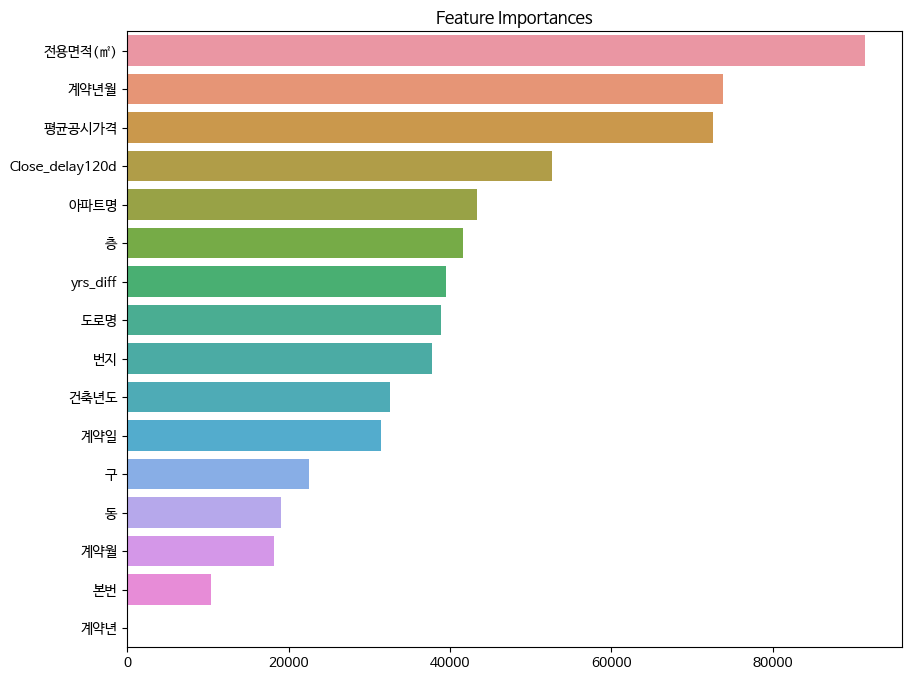

In [101]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [102]:
preds_df.describe().round(2)

,target
count,9272.00
mean,108686.30
std,76983.47
min,932.00
25%,63692.50
50%,88817.00
75%,128366.00
max,1260578.00


In [103]:
best_model.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('rmse', 3526.638678144426),
                          ('l2', 12437180.366184268)]),
             'valid_1': OrderedDict([('rmse', 5615.720787068876),
                          ('l2', 31536319.95831748)])})

In [104]:
val_pred = best_model.predict(X_val)

[LightGBM] [Warning] feature_fraction is set=0.9746451656926525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9746451656926525
[LightGBM] [Warning] lambda_l2 is set=0.5031506208685331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5031506208685331
[LightGBM] [Warning] lambda_l1 is set=1.7220445765101564e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7220445765101564e-07
[LightGBM] [Warning] bagging_fraction is set=0.9916422539381482, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9916422539381482


In [105]:
val_preds_df = pd.DataFrame(val_pred.astype(float), columns=["target"])

In [106]:
X_val['pred'] = val_preds_df['target']

In [107]:
X_val

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,구,동,계약년,계약월,평균공시가격,계약일,yrs_diff,Close_delay120d,pred
859108,1486,514,3731,105.360,201211,1,1993,5579,4,0,2012,10,42541.248470,4,19,1926.42,NaN
261109,3986,979,5128,39.920,202105,13,1990,5079,8,0,2021,4,30138.854806,7,31,2485.87,NaN
382608,2442,716,3776,82.710,202007,14,1993,126,21,0,2020,6,27409.310345,7,27,2229.26,NaN
2938,386,101,1837,84.465,201808,5,2007,5000,0,42,2018,7,190312.903226,27,11,2402.16,91779.247481
187091,5908,1360,3515,84.940,200902,2,2008,8365,17,94,2009,1,67296.000000,28,1,1383.50,40159.340206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756411,4954,1200,5260,115.530,201503,6,1993,1437,22,96,2015,2,45184.439608,10,22,2034.16,NaN
528485,2695,763,2124,74.190,201706,11,1987,3486,18,0,2017,5,88268.451613,13,30,2036.87,NaN
468126,3801,936,5196,59.820,201709,7,2000,440,6,0,2017,8,21390.277778,22,17,2164.64,NaN
123810,1902,615,4988,59.940,201112,9,2003,4729,16,0,2011,11,36148.393195,19,8,2062.91,142587.549251


In [109]:
X_val['error'] = X_val['pred'] - X_val['target'].astype(float)

KeyError: 'target'